In [1]:
!pip install tensorflow==2.0.0-beta1

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta1


In [0]:
def plot_series(time, series, format = "-", start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-09-25 07:17:28--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-09-25 07:17:28 (97.9 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



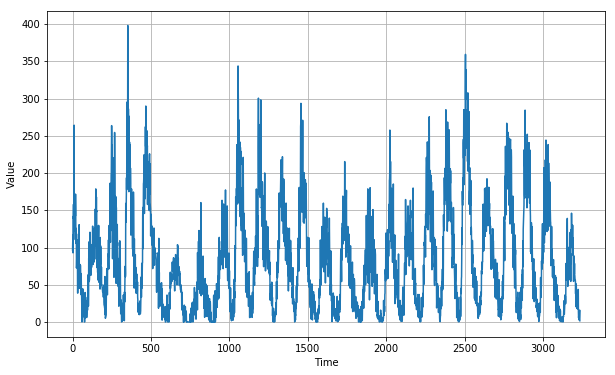

In [5]:
import csv

time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as file:
  reader = csv.reader(file, delimiter = ',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))
    
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize = (10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1,
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1,
                 drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size,
                             shuffle_buffer_size)

print(train_set)
print(x_train.shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)


In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.Dense(30, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [11]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(train_set, epochs = 100,
                    callbacks = [lr_schedule])

Epoch 1/100
12/12 [==============================] - 8s 674ms/step - loss: 81.4659 - mae: 81.9300
Epoch 2/100
12/12 [==============================] - 5s 433ms/step - loss: 80.2777 - mae: 80.7622
Epoch 3/100
12/12 [==============================] - 5s 438ms/step - loss: 78.5285 - mae: 79.0216
Epoch 4/100
12/12 [==============================] - 5s 441ms/step - loss: 76.5282 - mae: 77.0205
Epoch 5/100
12/12 [==============================] - 5s 442ms/step - loss: 74.4518 - mae: 74.9373
Epoch 6/100
12/12 [==============================] - 5s 434ms/step - loss: 72.4021 - mae: 72.8779
Epoch 7/100
12/12 [==============================] - 5s 441ms/step - loss: 70.4526 - mae: 70.9178
Epoch 8/100
12/12 [==============================] - 5s 439ms/step - loss: 68.6529 - mae: 69.1076
Epoch 9/100
12/12 [==============================] - 5s 443ms/step - loss: 67.0212 - mae: 67.4651
Epoch 10/100
12/12 [==============================] - 5s 437ms/step - loss: 65.5511 - mae: 65.9842
Epoch 11/100
12/12 

[1e-08, 0.0001, 0, 60]

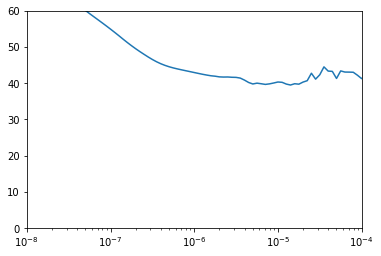

In [12]:
plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size = 60,
                             batch_size = 100,
                             shuffle_buffer = shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 60, kernel_size = 5,
                           strides = 1, padding = "causal",
                           activation = "relu",
                           input_shape = [None, 1]),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.LSTM(60, return_sequences = True),
    tf.keras.layers.Dense(30, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

In [14]:
optimizer = tf.keras.optimizers.SGD(lr = 1e-5, momentum = 0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])

history = model.fit(train_set, epochs = 500)

Epoch 1/500
30/30 [==============================] - 7s 249ms/step - loss: 52.3767 - mae: 53.1961
Epoch 2/500
30/30 [==============================] - 5s 158ms/step - loss: 42.9499 - mae: 43.6111
Epoch 3/500
30/30 [==============================] - 5s 158ms/step - loss: 41.3729 - mae: 42.0333
Epoch 4/500
30/30 [==============================] - 5s 157ms/step - loss: 41.0410 - mae: 41.7034
Epoch 5/500
30/30 [==============================] - 5s 157ms/step - loss: 40.5987 - mae: 41.2718
Epoch 6/500
30/30 [==============================] - 5s 157ms/step - loss: 40.0340 - mae: 40.7000
Epoch 7/500
30/30 [==============================] - 5s 157ms/step - loss: 39.7177 - mae: 40.3858
Epoch 8/500
30/30 [==============================] - 5s 157ms/step - loss: 39.6128 - mae: 40.2777
Epoch 9/500
30/30 [==============================] - 5s 157ms/step - loss: 39.2222 - mae: 39.8932
Epoch 10/500
30/30 [==============================] - 5s 157ms/step - loss: 39.1420 - mae: 39.8038
Epoch 11/500
30/30 

In [0]:
lstm_forecast = model_forecast(model, series[..., np.newaxis],
                               window_size)

lstm_forecast = lstm_forecast[split_time - window_size : -1, -1, 0]

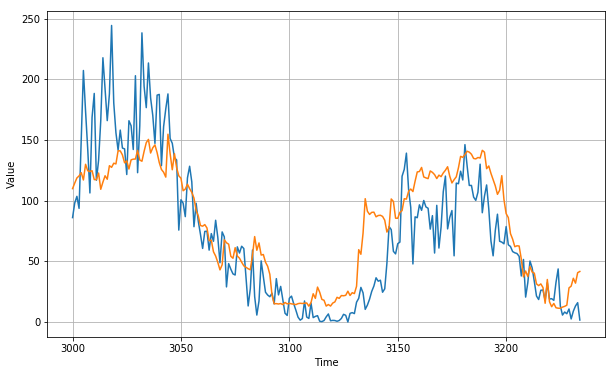

In [16]:
plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()

24.847672

<Figure size 432x288 with 0 Axes>

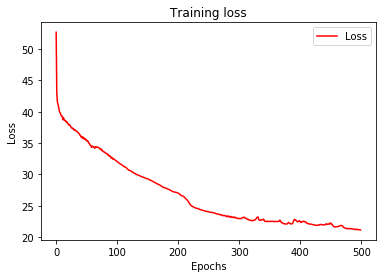

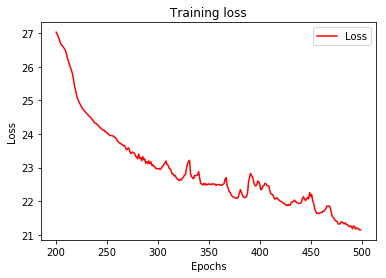

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on trainng and test data
# sets for each training epoch
#-----------------------------------------------------------

loss = history.history['loss']

epochs = range(len(loss))    # Get number of epochs

#-----------------------------------------------------------
# Plot training and validation loss per epoch
#-----------------------------------------------------------

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

#-----------------------------------------------------------
# Plot zoomed training and validation loss per epoch
#-----------------------------------------------------------

zoomed_loss = loss[200:]
zoomed_epochs = range(200, 500)

plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [19]:
print(lstm_forecast)

[109.876465  114.44299   118.65522   120.34283   123.01245   117.00437
 129.89722   124.57688   123.98614   124.6232    117.321846  117.314
 122.72402   109.323944  115.23984   120.46386   117.60092   128.76007
 127.408455  130.79945   130.21329   141.03975   140.95404   137.66432
 131.08661   132.86223   126.02537   133.60132   134.1521    134.26344
 141.45163   133.44221   132.43082   140.57726   147.72694   150.42726
 139.2102    143.51231   145.88875   139.52437   131.30908   125.64299
 123.37172   119.354866  154.6904    138.66138   125.416824  138.67693
 127.141045  120.42533   118.43283   108.109726  109.48147   113.48164
 109.82869   106.769775  102.10442    91.86871    87.30037    79.46442
  78.91366    80.21863    77.465805   66.97193    67.42078    57.85657
  54.33001    49.101265   42.92122    47.12664    67.689125   65.237305
  64.1075     54.14128    52.476036   61.211006   54.330647   52.562885
  49.27133    46.25012    45.09759    43.857224   43.008186   55.07186
  70.3